## RL Games

In [1]:
from IPython.display import clear_output

!pip install gym
!pip install nqueens
!pip install -U ray

!gdown --id 1lXBaqqOzMnmr7F04T9H2UnbTyN9g4Pjs
!gdown --id 1TTByOPj9JvBGS6I5B71u5qxaKKIXB9JZ
!gdown --id 1SPeH3NlXETsdVzRTV0YqwWRwcRmUMgao

!mkdir /content/save

clear_output()

In [5]:
import gym
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete
from nqueens import Queen
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import random
import tqdm
import os
import gc
import copy

import cv2
#from google.colab.patches import cv2_imshow


from IPython.display import HTML
from collections import namedtuple, deque
from itertools import count
from base64 import b64encode


from IPython import display

import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque,namedtuple


## Environment

In [ ]:
class Vasuki(Env):

    def _food_position_(self, n):
        # Using the N-Queens problem to uniformly distribute the food spawning location
        qq = Queen(n)
        food_pos = np.empty(shape = [0, 2])
        chess = qq.queen_data[0]
        for x in range(n):
            for y in range(n):
                if chess[y][x] == 1:
                    arr = np.array([[x, y]])
                    food_pos = np.append(food_pos, arr, axis = 0)
        # Returning the n food locations which are spatially distributed uniformly
        return food_pos
    
    def _init_agent_(self, score=0):
        # Creating a dictionary to store the information related to the agent
        agent = {}
        # Set initial direction of head of the Snake :  North = 0, East = 1, South = 2, West = 3
        agent['head'] = np.random.randint(low = 0, high = 4, size = (1)).item()
        # The score for each agent
        agent['score'] = score
        # Set initial position 
        agent['state'] = np.random.randint(low = 0, high = self.n, size = (2))
        # Velocity of the snake
        agent['velocity'] = 1            
        # Returning the Agent Properties
        return agent

    def _init_image_(self, path):
        # Loading the image
        image = cv2.imread(path)
        # Resizing the image
        image = cv2.resize(image, (self.scale-1,self.scale-1), interpolation=cv2.INTER_NEAREST)
        # Returning the preprocessed image
        return image

    def __init__(self, n, rewards, game_length=100):
        # Parameters
        self.n = n
        self.rewards = rewards
        self.scale = 256//self.n
        # Actions we can take : left = 0, forward = 1, right = 2
        self.action_space = Discrete(3)
        # The nxn grid
        self.observation_space = MultiDiscrete([self.n, self.n])
        # Set Total Game length
        self.game_length = game_length
        self.game_length_ = self.game_length
        # Set Food Spawning locations. Totally there are only n locations
        self.foodspawn_space = self._food_position_(self.n)
        # Out of the n food locations, at any time only n/2 random locations have food
        self.live_index = np.random.choice(len(self.foodspawn_space), size=(self.n//2), replace=False)
        self.live_foodspawn_space = self.foodspawn_space[self.live_index]
        # Initializing the Agents
        self.agentA = self._init_agent_()
        self.agentB = self._init_agent_()
        # Loading the Images
        self.image_agentA = self._init_image_("agentA.png")
        self.image_agentB = self._init_image_("agentB.png")
        self.image_prey = self._init_image_("prey.png")
        # Creating History
        encoded, _ = self.encode()
        self.history = [] # {"agentA": self.agentA, "agentB":self.agentB, "live_foodspawn_space": self.live_foodspawn_space, 'encoded': encoded}

    def _movement_(self, action, agent):
        # Loading the states
        illegal = 0     # If the snake hits the walls
        n = self.n
        head = agent['head']
        state = agent['state'].copy()
        velocity = agent['velocity']
        score = agent['score']
        # Applying the Action
        if action == 0: # Go Left
            if head==0:
                if state[1]==velocity-1: # Left Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([0, -velocity])
                head = 3
            elif head==1:
                if state[0]==velocity-1: # Top Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([-velocity, 0])
                head = 0
            elif head==2: 
                if state[1]==n-velocity: # Right Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([0, velocity])
                head = 1
            elif head==3:
                if state[0]==n-velocity: # Bottom Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([velocity, 0])
                head = 2           
        elif action == 1: # Move Forward
            if head==0:
                if state[0]==velocity-1: # Top Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([-velocity, 0])
                head = 0
            elif head==1:
                if state[1]==n-velocity: # Right Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([0, velocity])
                head = 1
            elif head==2:
                if state[0]==n-velocity: # Bottom Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([velocity, 0])
                head = 2
            elif head==3:
                if state[1]==velocity-1: # Left Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([0, -velocity])
                head = 3
        elif action == 2: # Go Right
            if head==0:
                if state[1]==n-velocity: # Right Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([0, velocity])
                head = 1
            elif head==1:
                if state[0]==n-velocity: # Bottom Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([velocity, 0])
                head = 2
            elif head==2:
                if state[1]==velocity-1: # Left Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([0, -velocity])
                head = 3
            elif head==3:
                if state[0]==velocity-1: # Top Wall
                    illegal = 1
                    change = np.array([0, 0])
                else:
                    change = np.array([-velocity, 0])
                head = 0
        # Updating the agent properties
        modified = {'head': head, 'state':state+change, 'score':score, 'velocity':velocity}
        return modified, illegal

    def _reward_(self, agent, illegal):
        # Loading the states
        head = agent['head']
        state = agent['state'].copy()
        velocity = agent['velocity']
        score = agent['score']
        # Calculating the reward
        if illegal == 1: # If the snake hits the wall
            reward = self.rewards['Illegal']
        else:
            if True in np.all((state == self.live_foodspawn_space), axis = 1):
                # Finding the index of the state
                index = np.where(np.all((state == self.live_foodspawn_space), axis = 1) == True)[0].item()
                # Computing the empty foodspawn spaces
                empty_foodspawn_space = [space for space in self.foodspawn_space if space not in self.live_foodspawn_space]
                # Removing the state from live foodspawn space
                self.live_foodspawn_space = np.delete(self.live_foodspawn_space, index, 0)
                # Updating the live foodspawn space
                addition = np.random.choice(len(empty_foodspawn_space), size=1, replace=False)
                self.live_foodspawn_space = np.append(self.live_foodspawn_space, np.expand_dims(empty_foodspawn_space[addition.item(0)], axis = 0), axis=0)
                assert  len(set([(x,y) for (x,y) in self.live_foodspawn_space])) == 4
                # If the snake lands on the food
                reward = self.rewards['Food']
            else:
                # If the snake just moves
                reward = self.rewards['Movement']
        return reward

    def step(self, action):
        actionA = action['actionA']
        actionB = action['actionB']
        # Applying the actions
        self.agentA, illegalA = self._movement_(actionA, self.agentA)
        self.agentB, illegalB = self._movement_(actionB, self.agentB) 
        # Calculating the reward
        if (self.agentA['state'] == self.agentB['state']).all():
            if self.agentA['score'] > self.agentB['score']:
                rewardA = 5 * abs( self.agentB['score']//(self.agentA['score']-self.agentB['score']) )
                rewardB = - 3 * abs( self.agentB['score']//(self.agentA['score']-self.agentB['score']) )
                _ = self._reward_(self.agentA, illegalA)
                score = self.agentB['score']
                while True:
                    self.agentB = self._init_agent_(score)
                    if (self.agentB['state']!=self.agentA['state']).all():
                        _ = self._reward_(self.agentB, illegalB)
                        break
            elif self.agentA['score'] < self.agentB['score']:
                rewardA = - 3 * abs( self.agentA['score']//(self.agentA['score']-self.agentB['score']) )
                rewardB = 5 * abs( self.agentA['score']//(self.agentA['score']-self.agentB['score']) )
                _ = self._reward_(self.agentB, illegalB)
                score = self.agentA['score']
                while True:
                    self.agentA = self._init_agent_(score) 
                    if (self.agentA['state']!=self.agentB['state']).all():
                        _ = self._reward_(self.agentA, illegalA)
                        break
            elif self.agentA['score'] == self.agentB['score']:
                rewardA = - abs(self.agentA['score']//2)
                rewardB = - abs(self.agentB['score']//2)
                while True:
                    self.agentA = self._init_agent_(score=self.agentA['score'])
                    if (self.agentA['state']!=self.agentB['state']).all():
                        _ = self._reward_(self.agentA, illegalA)
                        break
                while True:
                    self.agentB = self._init_agent_(score=self.agentB['score'])
                    if (self.agentB['state']!=self.agentA['state']).all():
                        _ = self._reward_(self.agentB, illegalB)
                        break
        else:
            rewardA = self._reward_(self.agentA, illegalA)
            rewardB = self._reward_(self.agentB, illegalB)
        # Adding the reward to the score
        self.agentA['score'] = self.agentA['score'] + rewardA
        self.agentB['score'] = self.agentB['score'] + rewardB
        # Updating history
        encoded, _ = self.encode()
        self.history.append({"agentA": self.agentA, "agentB":self.agentB, "live_foodspawn_space": self.live_foodspawn_space, "encoded": encoded, 
                             "rewardA": rewardA, "actionA": actionA, "rewardB": rewardB, "actionB": actionB})
        # Check if game is done
        self.game_length -= 1
        if self.game_length <= 0:
            done = True
        else:
            done = False
        # Set placeholder for info
        info = {'agentA': self.agentA, 'agentB': self.agentB}
        return  rewardA, rewardB, done, info

    def _rotate_(self, image, direction):
        # Rotating the image to rectify the direction of the head
        if direction == 1:
            image = np.rot90(image.copy(), k = 3)
        elif direction == 2: 
            image = np.rot90(image.copy(), k = 2)
        elif direction == 3:
            image = np.rot90(image.copy())
        return image

    def render(self, actionA, actionB): # Returns a one-hot encoded state
        # Loading the states
        live_foodspawn_space_ = self.history[-2]["live_foodspawn_space"]
        agentA = self.history[-2]["agentA"]
        agentB = self.history[-2]["agentB"]
        snakeA = agentA['state']
        snakeB = agentB['state']
        # Initializing the state
        state = np.ones((self.scale*self.n, 2*self.scale*self.n, 3))*255
        # Adding grid lines
        for x in range(self.n+1):
            state[self.scale*x:self.scale*x+1, :self.scale*self.n] = [0, 0, 0]
        for y in range(self.n+1):
            state[:, self.scale*y:self.scale*y+1] = [0, 0, 0]
        # Adding the live food location
        assert  len(set([(x,y) for (x,y) in live_foodspawn_space_])) == 4
        for food in live_foodspawn_space_.tolist():
            x = int(food[0])
            y = int(food[1])
            state[self.scale*x+1:self.scale*x+self.scale, self.scale*y+1:self.scale*y+self.scale] = self.image_prey
        # Annotating
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 0.4
        color = (0, 0, 0)
        thickness = 1
        direction = {0:"North", 1:"East", 2:"South", 3:"West"}
        action = {0:"Left", 1:"Forward", 2:"Right", "None":"None"}
        stateA = "State A: [{0},{1}]".format(snakeA[0], snakeA[1])
        stateB = "State B: [{0},{1}]".format(snakeB[0], snakeB[1])
        scoreA = "Score A: " + str(agentA['score'])
        scoreB = "Score B: " + str(agentB['score'])
        headA = "Head A: " + direction[agentA['head']]
        headB = "Head B: " + direction[agentB['head']]
        actionA = "Action A: " + action[actionA]
        actionB = "Action B: " + action[actionB]
        # Adding the text
        start = 80
        state = cv2.putText(state, scoreA, (265, start), font, fontScale, color, thickness, cv2.LINE_AA)
        state = cv2.putText(state, stateA, (265, start+32), font, fontScale, color, thickness, cv2.LINE_AA)
        state = cv2.putText(state, headA, (265, start+64), font, fontScale, color, thickness, cv2.LINE_AA)
        state = cv2.putText(state, actionA, (265, start+96), font, fontScale, color, thickness, cv2.LINE_AA)
        state = cv2.putText(state, scoreB, (390, start), font, fontScale, color, thickness, cv2.LINE_AA)
        state = cv2.putText(state, stateB, (390, start+32), font, fontScale, color, thickness, cv2.LINE_AA)
        state = cv2.putText(state, headB, (390, start+64), font, fontScale, color, thickness, cv2.LINE_AA)
        state = cv2.putText(state, actionB, (390, start+96), font, fontScale, color, thickness, cv2.LINE_AA)
        # Adding the agents
        image_agentA = self._rotate_(self.image_agentA, agentA['head'])
        image_agentB = self._rotate_(self.image_agentB, agentB['head'])
        state[self.scale*snakeA[0]+1:self.scale*snakeA[0]+self.scale, self.scale*snakeA[1]+1:self.scale*snakeA[1]+self.scale] = image_agentA
        state[self.scale*snakeB[0]+1:self.scale*snakeB[0]+self.scale, self.scale*snakeB[1]+1:self.scale*snakeB[1]+self.scale] = image_agentB
        # Returning the state
        return state

    def encode(self):
        # Loading the states
        encoder = {'blank': 0, 'foodspawn_space': 1, 'agentA': 2, 'agentB': 3}
        state = np.zeros((self.n, self.n))
        live_foodspawn_space = self.live_foodspawn_space.astype(np.int)
        snakeA = self.agentA['state']
        snakeB = self.agentB['state']
        # Adding the agents and snakes
        state[live_foodspawn_space[:,0], live_foodspawn_space[:,1]] = encoder['foodspawn_space']
        state[snakeA[0], snakeA[1]] = encoder['agentA']
        state[snakeB[0], snakeB[1]] = encoder['agentB']
        # One-Hot encoding the state
        encoded = np.eye(len(encoder.keys()))[state.astype(np.int)]
        encoded = np.moveaxis(encoded, -1, 0)
        # Returning the encoded and state
        return encoded, state

    def reset(self):
        # Reset Total Game length
        self.game_length = self.game_length_
        # Reset Food Spawning locations
        self.foodspawn_space = self._food_position_(self.n)
        # Reset Live Food Spawning locations
        self.live_index = np.random.choice(len(self.foodspawn_space), size=(self.n//2), replace=False)
        self.live_foodspawn_space = self.foodspawn_space[self.live_index]
        # Reset Agents
        self.agentA = self._init_agent_()
        self.agentB = self._init_agent_()
        # Clear History
        self.history = []

In [ ]:
config = {'n': 8, 'rewards': {'Food': 4, 'Movement': -1, 'Illegal': -2}, 'game_length': 100} # You can change during training but not during evaluation

env = Vasuki(**config)

---

# **Model Implementation (DQN)**

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque,namedtuple
from torchsummary import summary

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,64),
                  nn.ReLU(),
                  nn.Linear(64,32),
                  nn.ReLU(),
                  nn.Linear(32,action_space_dim)
                )

    def forward(self, x):
        x = x.to(device)
        return self.linear(x)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) 
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory) 

def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions (this list includes all the actions but the optimal one)
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly from non_optimal_actions
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out/temperature, dim=0).cpu().numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    action = np.random.choice(all_possible_actions,p=softmax_out)
    
    return action, net_out.cpu().numpy()

In [ ]:
encoder_on_grid = {'blank': 0, 'foodspawn_space': 1, 'agentA': 2, 'agentB': 3}
head_orientations = {0:"North",1:"East",2:"South",3:"West"}

def get_encoded_state_16(env):
    '''returns a 16 dim vector'''
    food_locations = env.live_foodspawn_space.astype(np.int)
    agentA = env.agentA
    headA,scoreA,locA = agentA['head'],agentA['score'],agentA['state']
    agentB = env.agentB
    headB,scoreB,locB = agentB['head'],agentB['score'],agentB['state']

    state = np.zeros(16)
    state[:8] = food_locations.flatten()
    state[8:10] = locA.flatten()
    state[10:12] = locB.flatten()
    state[12] = headA
    state[13] = headB
    state[14] = scoreA
    state[15] = scoreB

    return state


def visualise_encoded_state_16(state):
    state = state.astype(int)
    food_locations = state[:8].reshape(4,2)
    locA = state[8:10]
    locB = state[10:12]
    headA = state[12]
    headB = state[13]
    scoreA = state[14]
    scoreB = state[15]

    grid = np.zeros((8,8))
    grid[food_locations[:,0],food_locations[:,1]] = encoder_on_grid['foodspawn_space']
    grid[locA[0],locA[1]] = encoder_on_grid['agentA']
    grid[locB[0],locB[1]] = encoder_on_grid['agentB']

    grid  = grid.astype(int)
    grid = grid.astype(str)
    grid[grid=='2'] ="A"
    grid[grid=='3']="B"
    grid[grid=='1']='F'

    print(grid)
    print("ScoreA:",scoreA)
    print("ScoreB:",scoreB)
    print("headA:",int(headA),head_orientations[headA])
    print("headB:",int(headB),head_orientations[headB])

In [ ]:
def get_encoded_state_68(env):
    ''' returns a 68 dim vector '''
    state = np.zeros(68)
    state[4:] = env.encode()[1].flatten() #[1] is because env.encode() returns two things, the first one is one-hot encoded which we arent using
    scoreA,scoreB = env.agentA['score'],env.agentB['score']
    headA,headB = env.agentA['head'],env.agentB['head']
    state[:4] = scoreA,scoreB,headA,headB
    return state

def visualise_encoded_state_68(encoded_state):    
    scoreA,scoreB,headA,headB = encoded_state[:4]
    grid_flat = encoded_state[4:]
    grid = grid_flat.reshape(8,8)
    grid  = grid.astype(int)
    grid = grid.astype(str)
    grid[grid=='2'] ="A"
    grid[grid=='3']="B"
    grid[grid=='1']="F"

    print(grid)
    print("ScoreA:",scoreA)
    print("ScoreB:",scoreB)
    print("headA:",int(headA),head_orientations[headA])
    print("headB:",int(headB),head_orientations[headB])

In [ ]:
def get_XinA(env):

    # Declaring the booleans
    food_is_behind_of_A = 0
    food_is_front_of_A = 0
    food_is_left_of_A = 0
    food_is_right_of_A = 0

    B_is_near = False
    B_is_behind_of_A_and_scoreA_more_than_scoreB = 0
    B_is_front_of_A_and_scoreA_more_than_scoreB = 0
    B_is_left_of_A_and_scoreA_more_than_scoreB = 0
    B_is_right_of_A_and_scoreA_more_than_scoreB = 0
    B_is_behind_of_A_and_scoreA_less_than_scoreB = 0
    B_is_front_of_A_and_scoreA_less_than_scoreB = 0
    B_is_left_of_A_and_scoreA_less_than_scoreB = 0
    B_is_right_of_A_and_scoreA_less_than_scoreB = 0

    border_is_left_of_A = 0
    border_is_right_of_A = 0
    border_is_front_of_A = 0

    # Finding the nearest food
    A_loc = [env.agentA["state"][0], env.agentA["state"][1]]
    food_locs = env.live_foodspawn_space
    rel_food_locs = [[loc[0] - A_loc[0], loc[1] - A_loc[1]] for loc in food_locs]
    food_dist_from_A = [abs(loc[0]) + abs(loc[1]) for loc in rel_food_locs]
    nearest_food_index = food_dist_from_A.index(min(food_dist_from_A))
    nearest_food_rel_loc = rel_food_locs[nearest_food_index]

    # Getting relative location of B. And proximity
    B_loc = [env.agentB["state"][0], env.agentB["state"][1]]
    rel_loc_of_B = [B_loc[0] - A_loc[0], B_loc[1] - A_loc[1]]
    if abs(rel_loc_of_B[0]) + abs(rel_loc_of_B[1]) == 2:
        B_is_near = True

    # Considering the head direction and updating booleans
    if env.agentA["head"] == 0:
        if nearest_food_rel_loc[0] > 0:
            food_is_behind_of_A = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_front_of_A = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_right_of_A = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_left_of_A = 1
        if B_is_near:
            if env.agentA["score"] > env.agentB["score"]:
                if rel_loc_of_B[0] > 0:
                    B_is_behind_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[0] < 0:
                    B_is_front_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[1] > 0:
                    B_is_right_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[1] < 0:
                    B_is_left_of_A_and_scoreA_more_than_scoreB = 1
            if env.agentA["score"] <= env.agentB["score"]:
                if rel_loc_of_B[0] > 0:
                    B_is_behind_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[0] < 0:
                    B_is_front_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[1] > 0:
                    B_is_right_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[1] < 0:
                    B_is_left_of_A_and_scoreA_less_than_scoreB = 1
        if A_loc[0] == 0:
            border_is_front_of_A = 1
        if A_loc[1] == 0:
            border_is_left_of_A = 1
        if A_loc[1] == 7:
            border_is_right_of_A = 1

    if env.agentA["head"] == 1:
        if nearest_food_rel_loc[0] > 0:
            food_is_right_of_A = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_left_of_A = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_front_of_A = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_behind_of_A = 1
        if B_is_near:
            if env.agentA["score"] > env.agentB["score"]:
                if rel_loc_of_B[0] > 0:
                    B_is_right_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[0] < 0:
                    B_is_left_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[1] > 0:
                    B_is_front_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[1] < 0:
                    B_is_behind_of_A_and_scoreA_more_than_scoreB = 1
            if env.agentA["score"] <= env.agentB["score"]:
                if rel_loc_of_B[0] > 0:
                    B_is_right_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[0] < 0:
                    B_is_left_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[1] > 0:
                    B_is_front_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[1] < 0:
                    B_is_behind_of_A_and_scoreA_less_than_scoreB = 1
        if A_loc[0] == 0:
            border_is_left_of_A = 1
        if A_loc[0] == 7:
            border_is_right_of_A = 1
        if A_loc[1] == 7:
            border_is_front_of_A = 1

    if env.agentA["head"] == 2:
        if nearest_food_rel_loc[0] > 0:
            food_is_front_of_A = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_behind_of_A = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_left_of_A = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_right_of_A = 1
        if B_is_near:
            if env.agentA["score"] > env.agentB["score"]:
                if rel_loc_of_B[0] > 0:
                    B_is_front_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[0] < 0:
                    B_is_behind_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[1] > 0:
                    B_is_left_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[1] < 0:
                    B_is_right_of_A_and_scoreA_more_than_scoreB = 1
            if env.agentA["score"] <= env.agentB["score"]:
                if rel_loc_of_B[0] > 0:
                    B_is_front_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[0] < 0:
                    B_is_behind_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[1] > 0:
                    B_is_left_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[1] < 0:
                    B_is_right_of_A_and_scoreA_less_than_scoreB = 1
        if A_loc[0] == 7:
            border_is_front_of_A = 1
        if A_loc[1] == 0:
            border_is_right_of_A = 1
        if A_loc[1] == 7:
            border_is_left_of_A = 1

    if env.agentA["head"] == 3:
        if nearest_food_rel_loc[0] > 0:
            food_is_left_of_A = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_right_of_A = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_behind_of_A = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_front_of_A = 1
        if B_is_near:
            if env.agentA["score"] > env.agentB["score"]:
                if rel_loc_of_B[0] > 0:
                    B_is_left_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[0] < 0:
                    B_is_right_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[1] > 0:
                    B_is_behind_of_A_and_scoreA_more_than_scoreB = 1
                if rel_loc_of_B[1] < 0:
                    B_is_front_of_A_and_scoreA_more_than_scoreB = 1
            if env.agentA["score"] <= env.agentB["score"]:
                if rel_loc_of_B[0] > 0:
                    B_is_left_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[0] < 0:
                    B_is_right_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[1] > 0:
                    B_is_behind_of_A_and_scoreA_less_than_scoreB = 1
                if rel_loc_of_B[1] < 0:
                    B_is_front_of_A_and_scoreA_less_than_scoreB = 1
        if A_loc[0] == 0:
            border_is_right_of_A = 1
        if A_loc[0] == 7:
            border_is_left_of_A = 1
        if A_loc[1] == 0:
            border_is_front_of_A = 1

    return [
        food_is_behind_of_A,
        food_is_front_of_A,
        food_is_left_of_A,
        food_is_right_of_A,
        B_is_behind_of_A_and_scoreA_more_than_scoreB,
        B_is_front_of_A_and_scoreA_more_than_scoreB,
        B_is_left_of_A_and_scoreA_more_than_scoreB,
        B_is_right_of_A_and_scoreA_more_than_scoreB,
        B_is_behind_of_A_and_scoreA_less_than_scoreB,
        B_is_front_of_A_and_scoreA_less_than_scoreB,
        B_is_left_of_A_and_scoreA_less_than_scoreB,
        B_is_right_of_A_and_scoreA_less_than_scoreB,
        border_is_left_of_A,
        border_is_right_of_A,
        border_is_front_of_A,
    ]

In [ ]:
def get_XinB(env):

    # Declaring the booleans
    food_is_behind_of_B = 0
    food_is_front_of_B = 0
    food_is_left_of_B = 0
    food_is_right_of_B = 0

    A_is_near = False
    A_is_behind_of_B_and_scoreB_more_than_scoreA = 0
    A_is_front_of_B_and_scoreB_more_than_scoreA = 0
    A_is_left_of_B_and_scoreB_more_than_scoreA = 0
    A_is_right_of_B_and_scoreB_more_than_scoreA = 0
    A_is_behind_of_B_and_scoreB_less_than_scoreA = 0
    A_is_front_of_B_and_scoreB_less_than_scoreA = 0
    A_is_left_of_B_and_scoreB_less_than_scoreA = 0
    A_is_right_of_B_and_scoreB_less_than_scoreA = 0

    border_is_left_of_B = 0
    border_is_right_of_B = 0
    border_is_front_of_B = 0

    # Finding the nearest food
    B_loc = [env.agentB["state"][0], env.agentB["state"][1]]
    food_locs = env.live_foodspawn_space
    rel_food_locs = [[loc[0] - B_loc[0], loc[1] - B_loc[1]] for loc in food_locs]
    food_dist_from_B = [abs(loc[0]) + abs(loc[1]) for loc in rel_food_locs]
    nearest_food_index = food_dist_from_B.index(min(food_dist_from_B))
    nearest_food_rel_loc = rel_food_locs[nearest_food_index]

    # Getting relative location of A. And proximity
    A_loc = [env.agentA["state"][0], env.agentA["state"][1]]
    rel_loc_of_A = [A_loc[0] - B_loc[0], A_loc[1] - B_loc[1]]
    if abs(rel_loc_of_A[0]) + abs(rel_loc_of_A[1]) == 2:
        A_is_near = True

    # Considering the head direction and updating booleans
    if env.agentB["head"] == 0:
        if nearest_food_rel_loc[0] > 0:
            food_is_behind_of_B = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_front_of_B = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_right_of_B = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_left_of_B = 1
        if A_is_near:
            if env.agentB["score"] > env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_behind_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_front_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_right_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_left_of_B_and_scoreB_more_than_scoreA = 1
            if env.agentB["score"] <= env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_behind_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_front_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_right_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_left_of_B_and_scoreB_less_than_scoreA = 1
        if B_loc[0] == 0:
            border_is_front_of_B = 1
        if B_loc[1] == 0:
            border_is_left_of_B = 1
        if B_loc[1] == 7:
            border_is_right_of_B = 1

    if env.agentB["head"] == 1:
        if nearest_food_rel_loc[0] > 0:
            food_is_right_of_B = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_left_of_B = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_front_of_B = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_behind_of_B = 1
        if A_is_near:
            if env.agentB["score"] > env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_right_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_left_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_front_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_behind_of_B_and_scoreB_more_than_scoreA = 1
            if env.agentB["score"] <= env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_right_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_left_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_front_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_behind_of_B_and_scoreB_less_than_scoreA = 1
        if B_loc[0] == 0:
            border_is_left_of_B = 1
        if B_loc[0] == 7:
            border_is_right_of_B = 1
        if B_loc[1] == 7:
            border_is_front_of_B = 1

    if env.agentB["head"] == 2:
        if nearest_food_rel_loc[0] > 0:
            food_is_front_of_B = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_behind_of_B = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_left_of_B = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_right_of_B = 1
        if A_is_near:
            if env.agentB["score"] > env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_front_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_behind_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_left_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_right_of_B_and_scoreB_more_than_scoreA = 1
            if env.agentB["score"] <= env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_front_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_behind_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_left_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_right_of_B_and_scoreB_less_than_scoreA = 1
        if B_loc[0] == 7:
            border_is_front_of_B = 1
        if B_loc[1] == 0:
            border_is_right_of_B = 1
        if B_loc[1] == 7:
            border_is_left_of_B = 1

    if env.agentB["head"] == 3:
        if nearest_food_rel_loc[0] > 0:
            food_is_left_of_B = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_right_of_B = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_behind_of_B = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_front_of_B = 1
        if A_is_near:
            if env.agentB["score"] > env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_left_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_right_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_behind_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_front_of_B_and_scoreB_more_than_scoreA = 1
            if env.agentB["score"] <= env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_left_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_right_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_behind_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_front_of_B_and_scoreB_less_than_scoreA = 1
        if B_loc[0] == 0:
            border_is_right_of_B = 1
        if B_loc[0] == 7:
            border_is_left_of_B = 1
        if B_loc[1] == 0:
            border_is_front_of_B = 1

    return [
        food_is_behind_of_B,
        food_is_front_of_B,
        food_is_left_of_B,
        food_is_right_of_B,
        A_is_behind_of_B_and_scoreB_more_than_scoreA,
        A_is_front_of_B_and_scoreB_more_than_scoreA,
        A_is_left_of_B_and_scoreB_more_than_scoreA,
        A_is_right_of_B_and_scoreB_more_than_scoreA,
        A_is_behind_of_B_and_scoreB_less_than_scoreA,
        A_is_front_of_B_and_scoreB_less_than_scoreA,
        A_is_left_of_B_and_scoreB_less_than_scoreA,
        A_is_right_of_B_and_scoreB_less_than_scoreA,
        border_is_left_of_B,
        border_is_right_of_B,
        border_is_front_of_B,
    ]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
state_space_dim = 15
action_space_dim = 3

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)

gamma = 0.9
replay_memory_capacity = 1000   
lr = 2e-3
target_net_update_steps = 10   
batch_size = 32
bad_state_penalty = 0   
min_samples_for_training = 100  

# replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

# policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

# target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

loss_fn = nn.SmoothL1Loss()

STATE SPACE SIZE: 15
ACTION SPACE SIZE: 3


In [ ]:
summary(policy_net,[[state_space_dim]])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,024
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
              ReLU-6                   [-1, 32]               0
            Linear-7                    [-1, 3]              99
Total params: 7,363
Trainable params: 7,363
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor(np.array([s[0] for s in batch]), dtype=torch.float32, device=device)
    actions     = torch.tensor(np.array([s[1] for s in batch]), dtype=torch.int64, device=device)
    rewards     = torch.tensor(np.array([s[3] for s in batch]), dtype=torch.float32, device=device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute Q values 
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1).to(device))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)# Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping 
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

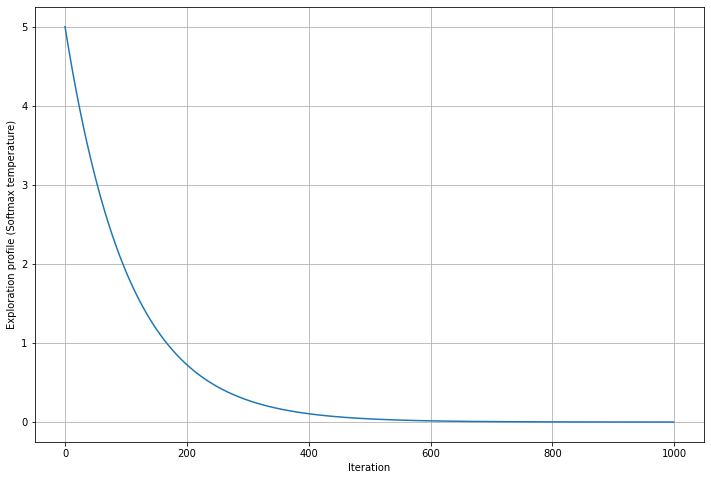

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

###**Training Code**

In [ ]:
plotting_rewards=[]
A_wins = 0
B_wins = 0
score = 5
q_values = 0
A_scores = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):

    env.reset()
    state = get_XinA(env)

    done = False

    while not done:

      # Choose the action following the policy
        #actionA, q_values = choose_action_softmax(policy_net, state, temperature=tau)
        actionA, q_values = choose_action_epsilon_greedy(policy_net,state,epsilon=0)
        #actionB = np.random.choice([0,1,2])
        #action_A,_ = choose_action_softmax(policy_net_loaded, state, 0)
        stateB = get_XinB(env)
        actionB, _ = choose_action_softmax(policy_net_loaded, stateB, 0)
        rewardA, rewardB, done, info = env.step({"actionA":actionA,"actionB":actionB})

        if done:  
            next_state = None
            #if env.agentA['score']>env.agentB['score']:
             #   reward = 0

            #else:
                #reward = 0 

        else:
            next_state = get_XinA(env)

      # Update the replay memory
        replay_mem.push(state, actionA, next_state, rewardA)

      # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Set the current state for the next iteration
        state = next_state

    match_status = ''
    scoreA = env.agentA['score']
    scoreB = env.agentB['score']
    A_scores.append(scoreA)
    if scoreA>scoreB:
        match_status = "Won"
        A_wins+=1
        score+=1
    elif scoreA<scoreB:
        match_status = "Loss"
        B_wins+=1
    elif scoreA==scoreB:
        match_status = "Tie!"
        B_wins+=1

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        plotting_rewards.append(score)
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
        print("Last {} Games: {}".format(target_net_update_steps,score))
        #print("A_total:{} B_total:{}".format(A_wins,B_wins))
        score = 0
        print("Q_values",q_values)
        print("Average A score",sum(A_scores[-10:])/target_net_update_steps, A_scores[-10:])
    
    print(f"EPISODE: {episode_num + 1} - RESULT: {match_status} - Temperature: {tau}") # Print the final score

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
Last 10 Games: 6
Q_values [-0.52317905 -0.5423622   1.2745748 ]
Average A score 1.6 [16]
EPISODE: 1 - RESULT: Won - Temperature: 5.0
EPISODE: 2 - RESULT: Loss - Temperature: 4.951949240166454
EPISODE: 3 - RESULT: Won - Temperature: 4.904360255437024
EPISODE: 4 - RESULT: Tie! - Temperature: 4.857228608082785
EPISODE: 5 - RESULT: Won - Temperature: 4.810549903022062
EPISODE: 6 - RESULT: Loss - Temperature: 4.764319787410582
EPISODE: 7 - RESULT: Loss - Temperature: 4.7185339502355665
EPISODE: 8 - RESULT: Won - Temperature: 4.673188121913726
EPISODE: 9 - RESULT: Won - Temperature: 4.628278073893115
EPISODE: 10 - RESULT: Loss - Temperature: 4.583799618258813
Updating target network...
Last 10 Games: 4
Q_values [-0.627301  -0.5895327  1.0334914]
Average A score 9.0 [-9, 4, 0, 40, 5, -13, 25, 39, -3, 2]
EPISODE: 11 - RESULT: Loss - Temperature: 4.5397486073424025
EPISODE: 12 - RESULT: Won - Temperature: 4.4961209333351855
EPISODE: 13 - RESULT: Loss - Temperature: 4.

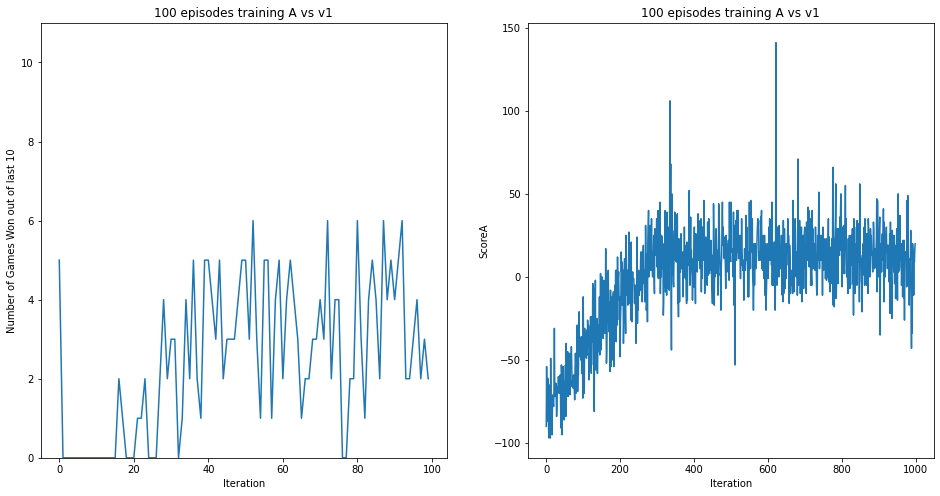

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(plotting_rewards)
plt.ylim(0,11)
plt.ylabel("Number of Games Won out of last 10")
plt.xlabel("Iteration")
plt.title("100 episodes training A vs v1")

plt.subplot(1,2,2)
plt.plot(A_scores)
plt.ylabel("ScoreA")
plt.xlabel("Iteration")
plt.title("100 episodes training A vs v1")

plt.show()

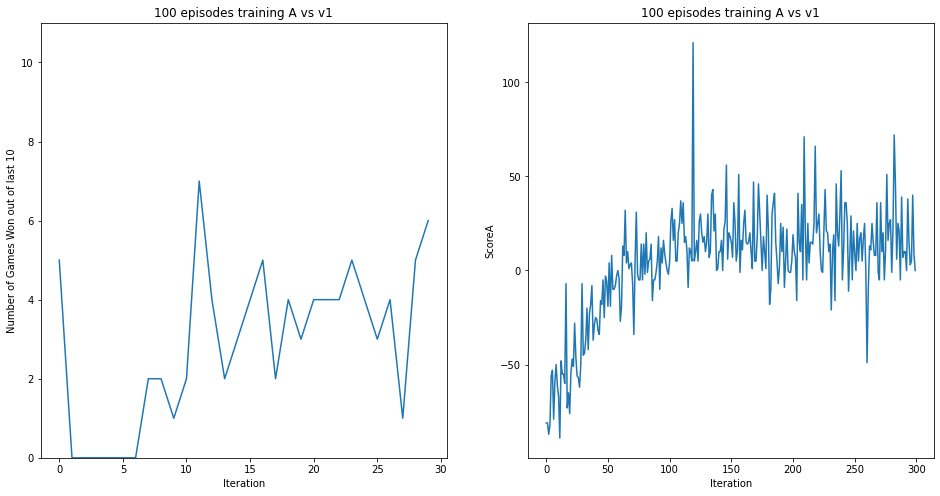

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(plotting_rewards)
plt.ylim(0,11)
plt.ylabel("Number of Games Won out of last 10")
plt.xlabel("Iteration")
plt.title("100 episodes training A vs random agent")

plt.subplot(1,2,2)
plt.plot(A_scores)
plt.ylabel("ScoreA")
plt.xlabel("Iteration")
plt.title("100 episodes training A vs random agent")

plt.show()

### **Trained Model Analyser**

In [ ]:
for i in range(10):
    env.step({"actionA":np.random.choice([0,1,2]),"actionB":np.random.choice([0,1,2])})
    actian_dist = policy_net(torch.tensor(get_encoded_state_16(env)).float()).cpu().detach().numpy()
    print("Optimal Action:",np.argmax(action_dist))
    #print("Probability Dist:",action_dist)

Optimal Action: 2
Optimal Action: 2
Optimal Action: 2
Optimal Action: 2
Optimal Action: 2
Optimal Action: 2
Optimal Action: 2
Optimal Action: 2
Optimal Action: 2
Optimal Action: 2


In [ ]:
env.reset()

In [ ]:
env.step({"actionA":2,"actionB":np.random.choice([0,1,2])})

(-1,
 -2,
 False,
 {'agentA': {'head': 0, 'score': -2, 'state': array([3, 2]), 'velocity': 1},
  'agentB': {'head': 2, 'score': -14, 'state': array([7, 3]), 'velocity': 1}})

In [ ]:
visualise_encoded_state_16(get_encoded_state_16(env))

[['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' 'F' '0']
 ['0' '0' '0' '0' 'F' '0' '0' '0']
 ['0' '0' 'A' '0' '0' '0' '0' 'F']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'F' '0' '0']
 ['0' '0' '0' 'B' '0' '0' '0' '0']]
ScoreA: -2
ScoreB: -14
headA: 0 North
headB: 2 South


In [ ]:
action_dist = policy_net(torch.tensor(get_encoded_state_16(env)).float()).cpu().detach().numpy()
print("Optimal Action:",np.argmax(action_dist))
print("Probability Dist:",action_dist)

Optimal Action: 2
Probability Dist: [-8.215822  -8.092945  -7.8088017]


In [ ]:
summary(policy_net,[[state_space_dim]])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,088
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 16]           1,040
              ReLU-4                   [-1, 16]               0
            Linear-5                    [-1, 3]              51
Total params: 2,179
Trainable params: 2,179
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


### Inferencer

In [ ]:
class Runner():
    def __init__(self, model_A, model_B, checkpoint):
        # Path to store the Video
        self.checkpoint = checkpoint
        # Defining the Environment
        config = {'n': 8, 'rewards': {'Food': 4, 'Movement': -1, 'Illegal': -2}, 'game_length': 100} # Should not change for evaluation
        self.env = Vasuki(**config)
        self.runs = 100
        # Trained Policies
        self.model_A = model_A # Loaded model with weights
        self.model_B = model_B # Loaded model with weights
        # Results
        self.winner = {'Player_A': 0, 'Player_B': 0}

    def reset(self):
        self.winner = {'Player_A': 0, 'Player_B': 0}

    def evaluate_A(self):
        # Uses self.env as the environment and returns the best action for Player A (Blue)
        state = get_XinA(self.env)
        action_A,_ = choose_action_softmax(policy_net, state, 0)
        return action_A # Action in {0, 1, 2}

    def evaluate_B(self):
        # Uses self.env as the environment and returns the best action for Player B (Red)
        stateB = get_XinB(self.env)
        action_B,_ = choose_action_softmax(policy_net_loaded, stateB, 0)
        return action_B # Action in {0, 1, 2}

    def visualize(self, run,comment):
        self.env.reset()
        done = False
        video = []
        while not done:
            # Actions based on the current state using the learned policy 
            actionA = self.evaluate_A()
            actionB = self.evaluate_B()
            action = {'actionA': actionA, 'actionB': actionB}
            rewardA, rewardB, done, info = self.env.step(action)
            # Rendering the enviroment to generate the simulation
            if len(self.env.history)>1:
                state = self.env.render(actionA, actionB)
                encoded, _ = self.env.encode()
                state = np.array(state, dtype=np.uint8)
                video.append(state)
        # Recording the Winner
        if self.env.agentA['score'] > self.env.agentB['score']:
            self.winner['Player_A'] += 1
        elif self.env.agentB['score'] > self.env.agentA['score']:
            self.winner['Player_B'] += 1
        # Generates a video simulation of the game
        if run%50==0:
            aviname = os.path.join(self.checkpoint, f"game_{run}_{comment}.avi")
            mp4name = os.path.join(self.checkpoint, f"game_{run}_{comment}.mp4")
            w, h, _ = video[0].shape
            out = cv2.VideoWriter(aviname, cv2.VideoWriter_fourcc(*'DIVX'), 2, (h, w))
            for state in video:
                assert state.shape==(256,512,3)
                out.write(state)
            cv2.destroyAllWindows()
            os.popen("ffmpeg -i {input} {output}".format(input=aviname, output=mp4name))
            os.popen("rm -f {input}".format(input=aviname))

    def arena(self,comment=''):
        # Pitching the Agents against each other
        for run in range(1, self.runs+1, 1):
            self.visualize(run, comment)
        return self.winner

runner = Runner(0,0,"/content/save")

In [ ]:
runner.arena("A vs itself")

{'Player_A': 35, 'Player_B': 62}

In [ ]:
runner.arena("random_A_3000_ep_diff_nn_16d")

{'Player_A': 89, 'Player_B': 11}

In [ ]:
runner.arena("random_A_reward100_2000_ep_diff_nn_16d")

{'Player_A': 94, 'Player_B': 6}

In [ ]:
runner.arena("random_A_2000_ep_diff_nn_16d")

{'Player_A': 184, 'Player_B': 14}

In [ ]:
runner.arena("random_A_1000_ep_diff_nn_16d")

{'Player_A': 91, 'Player_B': 9}

In [ ]:
runner.arena("1000_ep_diff_nn_16d")

{'Player_A': 61, 'Player_B': 37}

In [ ]:
runner.arena("-1_for_illegal_16dim_10000_ep")

{'Player_A': 0, 'Player_B': 100}

In [ ]:
runner.arena("16dim100_for_reward_200_ep")

{'Player_A': 137, 'Player_B': 59}

In [ ]:
runner.arena("100_for_reward_2000_ep")

{'Player_A': 136, 'Player_B': 61}

In [ ]:
runner.arena("100_for_reward")

{'Player_A': 59, 'Player_B': 36}

In [ ]:
runner.arena() #100 epochs, 100 for rat

{'Player_A': 62, 'Player_B': 35}

In [ ]:
runner.arena()

{'Player_A': 534, 'Player_B': 459}

In [ ]:
runner.arena()

{'Player_A': 70, 'Player_B': 29}

In [ ]:
runner.arena()

{'Player_A': 665, 'Player_B': 313}

In [ ]:
runner.arena()

{'Player_A': 341, 'Player_B': 151}

In [ ]:
runner.arena()

{'Player_A': 61, 'Player_B': 38}

In [ ]:
runner.arena()

{'Player_A': 62, 'Player_B': 38}

In [ ]:
policy_net.eval()

DQN(
  (linear): Sequential(
    (0): Linear(in_features=68, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [ ]:
s1 = get_encoded_state(env)

In [ ]:
policy_net(torch.tensor(s1).float())

tensor([-68.9399, -70.2744, -68.5683], device='cuda:0', grad_fn=<AddBackward0>)

### **Saving and Loading Model**

In [ ]:
policy_net_loaded = torch.load("/content/model_100_15_dim.pth")

In [ ]:
summary(policy_net_loaded,[[state_space_dim]])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,024
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
              ReLU-6                   [-1, 32]               0
            Linear-7                    [-1, 3]              99
Total params: 7,363
Trainable params: 7,363
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [ ]:
torch.save(policy_net,"/content/model_100_15_dim.pth")

# **Feed Forward Neural network with Policy Gradient methods**

In [ ]:
import gym
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete
from nqueens import Queen
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import random
import tqdm
import os
import gc
import copy

import cv2
#from google.colab.patches import cv2_imshow


from IPython.display import HTML
from collections import namedtuple, deque
from itertools import count
from base64 import b64encode


from IPython import display

import numpy as np
import gym
#%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
!pip3 uninstall tensorflow 
!pip3 install tensorflow==1.5

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Would remove:
    /Users/chetan/opt/anaconda3/bin/estimator_ckpt_converter
    /Users/chetan/opt/anaconda3/bin/import_pb_to_tensorboard
    /Users/chetan/opt/anaconda3/bin/saved_model_cli
    /Users/chetan/opt/anaconda3/bin/tensorboard
    /Users/chetan/opt/anaconda3/bin/tf_upgrade_v2
    /Users/chetan/opt/anaconda3/bin/tflite_convert
    /Users/chetan/opt/anaconda3/bin/toco
    /Users/chetan/opt/anaconda3/bin/toco_from_protos
    /Users/chetan/opt/anaconda3/lib/python3.7/site-packages/tensorflow-2.7.0.dist-info/*
    /Users/chetan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
ERROR: Could not find a version that satisfies the requirement tensorflow==1.5 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0r

In [ ]:
import tensorflow as tf

In [8]:
import session_info
session_info.show()

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(9, input_dim = 15, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.build()
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.005)
compute_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
gradBuffer= model.trainable_variables
for ix, grad in enumerate (gradBuffer):
  gradBuffer[ix] = grad * 0

In [ ]:
config = {'n': 8, 'rewards': {'Food': 50, 'Movement': -1, 'Illegal': -2}, 'game_length': 100}
env = Vasuki(**config)
episodes = 1000
scores_A = []
scores_B = []
update_every = 4

In [ ]:
def get_XinA(env):

  # Declaring the booleans
  food_is_behind_of_A = 0
  food_is_front_of_A = 0
  food_is_left_of_A = 0
  food_is_right_of_A = 0

  B_is_near = False
  B_is_behind_of_A_and_scoreA_more_than_scoreB = 0
  B_is_front_of_A_and_scoreA_more_than_scoreB = 0
  B_is_left_of_A_and_scoreA_more_than_scoreB = 0
  B_is_right_of_A_and_scoreA_more_than_scoreB = 0
  B_is_behind_of_A_and_scoreA_less_than_scoreB = 0
  B_is_front_of_A_and_scoreA_less_than_scoreB = 0
  B_is_left_of_A_and_scoreA_less_than_scoreB = 0
  B_is_right_of_A_and_scoreA_less_than_scoreB = 0

  border_is_left_of_A = 0
  border_is_right_of_A = 0
  border_is_front_of_A = 0
  


  # Finding the nearest food 
  A_loc = [env.agentA['state'][0], env.agentA['state'][1]]
  food_locs = env.live_foodspawn_space
  rel_food_locs = [[loc[0] - A_loc[0], loc[1] - A_loc[1]] for loc in food_locs]
  food_dist_from_A = [abs(loc[0]) + abs(loc[1]) for loc in rel_food_locs]
  nearest_food_index = food_dist_from_A.index(min(food_dist_from_A))
  nearest_food_rel_loc = rel_food_locs[nearest_food_index]

  # Getting relative location of B. And proximity
  B_loc = [env.agentB['state'][0], env.agentB['state'][1]]
  rel_loc_of_B = [B_loc[0] - A_loc[0], B_loc[1] - A_loc[1]] 
  if abs(rel_loc_of_B[0]) + abs(rel_loc_of_B[1]) == 2:
    B_is_near = True

  # Considering the head direction and updating booleans
  if env.agentA['head'] == 0:
    if nearest_food_rel_loc[0] > 0:
      food_is_behind_of_A = 1
    if nearest_food_rel_loc[0] < 0:
      food_is_front_of_A = 1
    if nearest_food_rel_loc[1] > 0:
      food_is_right_of_A = 1
    if nearest_food_rel_loc[1] < 0:
      food_is_left_of_A = 1
    if B_is_near:
      if env.agentA['score'] > env.agentB['score']:
        if rel_loc_of_B[0] > 0:
          B_is_behind_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[0] < 0:
          B_is_front_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[1] > 0:
          B_is_right_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[1] < 0:
          B_is_left_of_A_and_scoreA_more_than_scoreB = 1
      if env.agentA['score'] <= env.agentB['score']:
        if rel_loc_of_B[0] > 0:
          B_is_behind_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[0] < 0:
          B_is_front_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[1] > 0:
          B_is_right_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[1] < 0:
          B_is_left_of_A_and_scoreA_less_than_scoreB = 1
    if A_loc[0] == 0:
      border_is_front_of_A = 1
    if A_loc[1] == 0:
      border_is_left_of_A = 1
    if A_loc[1] == 7:
      border_is_right_of_A = 1
    
  if env.agentA['head'] == 1:
    if nearest_food_rel_loc[0] > 0:
      food_is_right_of_A = 1
    if nearest_food_rel_loc[0] < 0:
      food_is_left_of_A = 1
    if nearest_food_rel_loc[1] > 0:
      food_is_front_of_A = 1
    if nearest_food_rel_loc[1] < 0:
      food_is_behind_of_A = 1
    if B_is_near:
      if env.agentA['score'] > env.agentB['score']:
        if rel_loc_of_B[0] > 0:
          B_is_right_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[0] < 0:
          B_is_left_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[1] > 0:
          B_is_front_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[1] < 0:
          B_is_behind_of_A_and_scoreA_more_than_scoreB = 1
      if env.agentA['score'] <= env.agentB['score']:
        if rel_loc_of_B[0] > 0:
          B_is_right_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[0] < 0:
          B_is_left_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[1] > 0:
          B_is_front_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[1] < 0:
          B_is_behind_of_A_and_scoreA_less_than_scoreB = 1
    if A_loc[0] == 0:
      border_is_left_of_A = 1
    if A_loc[0] == 7:
      border_is_right_of_A = 1
    if A_loc[1] == 7:
      border_is_front_of_A = 1
    
  if env.agentA['head'] == 2:
    if nearest_food_rel_loc[0] > 0:
      food_is_front_of_A = 1
    if nearest_food_rel_loc[0] < 0:
      food_is_behind_of_A = 1
    if nearest_food_rel_loc[1] > 0:
      food_is_left_of_A = 1
    if nearest_food_rel_loc[1] < 0:
      food_is_right_of_A = 1
    if B_is_near:
      if env.agentA['score'] > env.agentB['score']:
        if rel_loc_of_B[0] > 0:
          B_is_front_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[0] < 0:
          B_is_behind_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[1] > 0:
          B_is_left_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[1] < 0:
          B_is_right_of_A_and_scoreA_more_than_scoreB = 1
      if env.agentA['score'] <= env.agentB['score']:
        if rel_loc_of_B[0] > 0:
          B_is_front_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[0] < 0:
          B_is_behind_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[1] > 0:
          B_is_left_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[1] < 0:
          B_is_right_of_A_and_scoreA_less_than_scoreB = 1
    if A_loc[0] == 7:
      border_is_front_of_A = 1
    if A_loc[1] == 0:
      border_is_right_of_A = 1
    if A_loc[1] == 7:
      border_is_left_of_A = 1

  if env.agentA['head'] == 3:
    if nearest_food_rel_loc[0] > 0:
      food_is_left_of_A = 1
    if nearest_food_rel_loc[0] < 0:
      food_is_right_of_A = 1
    if nearest_food_rel_loc[1] > 0:
      food_is_behind_of_A = 1
    if nearest_food_rel_loc[1] < 0:
      food_is_front_of_A = 1
    if B_is_near:
      if env.agentA['score'] > env.agentB['score']:
        if rel_loc_of_B[0] > 0:
          B_is_left_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[0] < 0:
          B_is_right_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[1] > 0:
          B_is_behind_of_A_and_scoreA_more_than_scoreB = 1
        if rel_loc_of_B[1] < 0:
          B_is_front_of_A_and_scoreA_more_than_scoreB = 1
      if env.agentA['score'] <= env.agentB['score']:
        if rel_loc_of_B[0] > 0:
          B_is_left_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[0] < 0:
          B_is_right_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[1] > 0:
          B_is_behind_of_A_and_scoreA_less_than_scoreB = 1
        if rel_loc_of_B[1] < 0:
          B_is_front_of_A_and_scoreA_less_than_scoreB = 1
    if A_loc[0] == 0:
      border_is_right_of_A = 1
    if A_loc[0] == 7:
      border_is_left_of_A = 1
    if A_loc[1] == 0:
      border_is_front_of_A = 1

  return [food_is_behind_of_A, food_is_front_of_A, food_is_left_of_A, food_is_right_of_A,
          B_is_behind_of_A_and_scoreA_more_than_scoreB, B_is_front_of_A_and_scoreA_more_than_scoreB, B_is_left_of_A_and_scoreA_more_than_scoreB, B_is_right_of_A_and_scoreA_more_than_scoreB,
          B_is_behind_of_A_and_scoreA_less_than_scoreB, B_is_front_of_A_and_scoreA_less_than_scoreB, B_is_left_of_A_and_scoreA_less_than_scoreB, B_is_right_of_A_and_scoreA_less_than_scoreB,
          border_is_left_of_A, border_is_right_of_A, border_is_front_of_A]





In [ ]:
def get_XinB(env):

    # Declaring the booleans
    food_is_behind_of_B = 0
    food_is_front_of_B = 0
    food_is_left_of_B = 0
    food_is_right_of_B = 0

    A_is_near = False
    A_is_behind_of_B_and_scoreB_more_than_scoreA = 0
    A_is_front_of_B_and_scoreB_more_than_scoreA = 0
    A_is_left_of_B_and_scoreB_more_than_scoreA = 0
    A_is_right_of_B_and_scoreB_more_than_scoreA = 0
    A_is_behind_of_B_and_scoreB_less_than_scoreA = 0
    A_is_front_of_B_and_scoreB_less_than_scoreA = 0
    A_is_left_of_B_and_scoreB_less_than_scoreA = 0
    A_is_right_of_B_and_scoreB_less_than_scoreA = 0

    border_is_left_of_B = 0
    border_is_right_of_B = 0
    border_is_front_of_B = 0

    # Finding the nearest food
    B_loc = [env.agentB["state"][0], env.agentB["state"][1]]
    food_locs = env.live_foodspawn_space
    rel_food_locs = [[loc[0] - B_loc[0], loc[1] - B_loc[1]] for loc in food_locs]
    food_dist_from_B = [abs(loc[0]) + abs(loc[1]) for loc in rel_food_locs]
    nearest_food_index = food_dist_from_B.index(min(food_dist_from_B))
    nearest_food_rel_loc = rel_food_locs[nearest_food_index]

    # Getting relative location of A. And proximity
    A_loc = [env.agentA["state"][0], env.agentA["state"][1]]
    rel_loc_of_A = [A_loc[0] - B_loc[0], A_loc[1] - B_loc[1]]
    if abs(rel_loc_of_A[0]) + abs(rel_loc_of_A[1]) == 2:
        A_is_near = True

    # Considering the head direction and updating booleans
    if env.agentB["head"] == 0:
        if nearest_food_rel_loc[0] > 0:
            food_is_behind_of_B = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_front_of_B = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_right_of_B = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_left_of_B = 1
        if A_is_near:
            if env.agentB["score"] > env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_behind_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_front_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_right_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_left_of_B_and_scoreB_more_than_scoreA = 1
            if env.agentB["score"] <= env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_behind_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_front_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_right_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_left_of_B_and_scoreB_less_than_scoreA = 1
        if B_loc[0] == 0:
            border_is_front_of_B = 1
        if B_loc[1] == 0:
            border_is_left_of_B = 1
        if B_loc[1] == 7:
            border_is_right_of_B = 1

    if env.agentB["head"] == 1:
        if nearest_food_rel_loc[0] > 0:
            food_is_right_of_B = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_left_of_B = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_front_of_B = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_behind_of_B = 1
        if A_is_near:
            if env.agentB["score"] > env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_right_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_left_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_front_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_behind_of_B_and_scoreB_more_than_scoreA = 1
            if env.agentB["score"] <= env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_right_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_left_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_front_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_behind_of_B_and_scoreB_less_than_scoreA = 1
        if B_loc[0] == 0:
            border_is_left_of_B = 1
        if B_loc[0] == 7:
            border_is_right_of_B = 1
        if B_loc[1] == 7:
            border_is_front_of_B = 1

    if env.agentB["head"] == 2:
        if nearest_food_rel_loc[0] > 0:
            food_is_front_of_B = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_behind_of_B = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_left_of_B = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_right_of_B = 1
        if A_is_near:
            if env.agentB["score"] > env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_front_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_behind_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_left_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_right_of_B_and_scoreB_more_than_scoreA = 1
            if env.agentB["score"] <= env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_front_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_behind_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_left_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_right_of_B_and_scoreB_less_than_scoreA = 1
        if B_loc[0] == 7:
            border_is_front_of_B = 1
        if B_loc[1] == 0:
            border_is_right_of_B = 1
        if B_loc[1] == 7:
            border_is_left_of_B = 1

    if env.agentB["head"] == 3:
        if nearest_food_rel_loc[0] > 0:
            food_is_left_of_B = 1
        if nearest_food_rel_loc[0] < 0:
            food_is_right_of_B = 1
        if nearest_food_rel_loc[1] > 0:
            food_is_behind_of_B = 1
        if nearest_food_rel_loc[1] < 0:
            food_is_front_of_B = 1
        if A_is_near:
            if env.agentB["score"] > env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_left_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_right_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_behind_of_B_and_scoreB_more_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_front_of_B_and_scoreB_more_than_scoreA = 1
            if env.agentB["score"] <= env.agentA["score"]:
                if rel_loc_of_A[0] > 0:
                    A_is_left_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[0] < 0:
                    A_is_right_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] > 0:
                    A_is_behind_of_B_and_scoreB_less_than_scoreA = 1
                if rel_loc_of_A[1] < 0:
                    A_is_front_of_B_and_scoreB_less_than_scoreA = 1
        if B_loc[0] == 0:
            border_is_right_of_B = 1
        if B_loc[0] == 7:
            border_is_left_of_B = 1
        if B_loc[1] == 0:
            border_is_front_of_B = 1

    return [
        food_is_behind_of_B,
        food_is_front_of_B,
        food_is_left_of_B,
        food_is_right_of_B,
        A_is_behind_of_B_and_scoreB_more_than_scoreA,
        A_is_front_of_B_and_scoreB_more_than_scoreA,
        A_is_left_of_B_and_scoreB_more_than_scoreA,
        A_is_right_of_B_and_scoreB_more_than_scoreA,
        A_is_behind_of_B_and_scoreB_less_than_scoreA,
        A_is_front_of_B_and_scoreB_less_than_scoreA,
        A_is_left_of_B_and_scoreB_less_than_scoreA,
        A_is_right_of_B_and_scoreB_less_than_scoreA,
        border_is_left_of_B,
        border_is_right_of_B,
        border_is_front_of_B
    ]


In [ ]:
for e in range(800):
  env.reset()
  ep_memory_A = []
  ep_memory_B = []
  ep_score_A = 0
  ep_score_B = 0
  epsilon = 0.6
  done = False

  while not done:
    XinA = get_XinA(env)

    with tf.GradientTape() as tape:
      XinA = np.array(XinA)
      logitsA = model(XinA.reshape(1,15))
      a_distA = logitsA.numpy()

      if epsilon < np.random.uniform():
        a_A = np.random.choice([0,1,2],p=a_distA[0])
      else:
        a_A = np.random.choice([0,1,2])

      a_B = np.random.choice([0,1,2])

      actions = {'actionA': a_A, 'actionB': a_B}

      loss_A = compute_loss([a_A], logitsA) 

    #Make the chosen action
    rewA, rewB, done, _ = env.step(actions)
    ep_score_A += rewA
    ep_score_B += rewB

    grads_A = tape.gradient(loss_A, model.trainable_variables)

    ep_memory_A.append([grads_A, rewA])

  scores_A.append(ep_score_A)
  scores_B.append(ep_score_B)
  
  ep_memory_A = np.array(ep_memory_A)

  for grads, r in ep_memory_A:
    for ix, grad in enumerate(grads):
      gradBuffer[ix] += grad * r

  if e % update_every == 0:
    optimizer.apply_gradients(zip(gradBuffer, model.trainable_variables))
    for ix, grad in enumerate(gradBuffer):
      gradBuffer[ix] = grad * 0

  if e % 4 == 0:
    print("Episode  {}   ScoreA  {}".format(e, np.mean(scores_A[-4:])))
    print("Episode  {}   ScoreB  {}".format(e, np.mean(scores_B[-4:])))

In [ ]:
class Runner1():
    def __init__(self, model_A, model_B, checkpoint):
        # Path to store the Video
        self.checkpoint = checkpoint
        # Defining the Environment
        config = {'n': 8, 'rewards': {'Food': 4, 'Movement': -1, 'Illegal': -2}, 'game_length': 100} # Should not change for evaluation
        self.env = Vasuki(**config)
        self.runs = 100
        # Trained Policies
        self.model_A = model_A # Loaded model with weights
        self.model_B = model_B # Loaded model with weights
        # Results
        self.winner = {'Player_A': 0, 'Player_B': 0}

    def reset(self):
        self.winner = {'Player_A': 0, 'Player_B': 0}

    def evaluate_A(self):
        XinA = get_XinA(self.env)
        XinA = np.array(XinA)
        logitsA = self.model_A(XinA.reshape(1,15))
        a_distA = logitsA.numpy()
        a_A = np.random.choice([0,1,2],p=a_distA[0])
        action_A = a_A

        return action_A # Action in {0, 1, 2}

    def evaluate_B(self):
        action_B = np.random.choice([0,1,2])
        
        return action_B # Action in {0, 1, 2}

    def visualize(self, run):
        self.env.reset()
        done = False
        video = []
        while not done:
            # Actions based on the current state using the learned policy 
            actionA = self.evaluate_A()
            actionB = self.evaluate_B()
            action = {'actionA': actionA, 'actionB': actionB}
            # print(action)
            rewardA, rewardB, done, info = self.env.step(action)
            # Rendering the enviroment to generate the simulation
            if len(self.env.history)>1:
                state = self.env.render(actionA, actionB)
                encoded, _ = self.env.encode()
                state = np.array(state, dtype=np.uint8)
                video.append(state)
        # Recording the Winner
        print(run)
        print(self.env.agentA['score'], self.env.agentB['score'])
        if self.env.agentA['score'] > self.env.agentB['score']:
            self.winner['Player_A'] += 1
        elif self.env.agentB['score'] > self.env.agentA['score']:
            self.winner['Player_B'] += 1
        # Generates a video simulation of the game
        if run%100==0:
            aviname = os.path.join(self.checkpoint, f"direct_game1_{run}.avi")
            mp4name = os.path.join(self.checkpoint, f"direct_game1_{run}.mp4")
            w, h, _ = video[0].shape
            out = cv2.VideoWriter(aviname, cv2.VideoWriter_fourcc(*'DIVX'), 2, (h, w))
            for state in video:
                assert state.shape==(256,512,3)
                out.write(state)
            cv2.destroyAllWindows()
            os.popen("ffmpeg -i {input} {output}".format(input=aviname, output=mp4name))
            # os.popen("rm -f {input}".format(input=aviname))

    def arena(self):
        # Pitching the Agents against each other
        for run in range(1, self.runs+1, 1):
            self.visualize(run)
        return self.winner

In [ ]:
runner1 = Runner1(model, model, "/content")

In [ ]:
runner1.arena()

In [ ]:
config = {'n': 8, 'rewards': {'Food': 50, 'Movement': -1, 'Illegal': -2}, 'game_length': 100}
env = Vasuki(**config)
episodes = 1000
scores_A = []
scores_B = []
update_every = 4

In [ ]:
for e in range(episodes):
  env.reset()
  ep_memory_A = []
  ep_memory_B = []
  ep_score_A = 0
  ep_score_B = 0
  epsilon = 0.6
  done = False

  while not done:
    XinA = get_XinA(env)
    XinB = get_XinB(env)

    with tf.GradientTape() as tape:

      XinA = np.array(XinA)
      logitsA = model(XinA.reshape(1,15))
      a_distA = logitsA.numpy()

      if epsilon < np.random.uniform():
        a_A = np.random.choice([0,1,2],p=a_distA[0])
      else:
        a_A = np.random.choice([0,1,2])

      XinB = np.array(XinB)
      logitsB = model(XinB.reshape(1,15))
      a_distB = logitsB.numpy()

      if epsilon < np.random.uniform():
        a_B = np.random.choice([0,1,2],p=a_distB[0])
      else:
        a_B = np.random.choice([0,1,2])

      actions = {'actionA': a_A, 'actionB': a_B}

      loss_A = compute_loss([a_A], logitsA) 

    #Make the chosen action
    rewA, rewB, done, _ = env.step(actions)

    ep_score_A += rewA
    ep_score_B += rewB

    grads_A = tape.gradient(loss_A, model.trainable_variables)
    ep_memory_A.append([grads_A, rewA])

  scores_A.append(ep_score_A)
  scores_B.append(ep_score_B)
  
  ep_memory_A = np.array(ep_memory_A)

  for grads, r in ep_memory_A:
    for ix, grad in enumerate(grads):
      gradBuffer[ix] += grad * r

  if e % update_every == 0:
    optimizer.apply_gradients(zip(gradBuffer, model.trainable_variables))
    for ix, grad in enumerate(gradBuffer):
      gradBuffer[ix] = grad * 0

  if e % 4 == 0:
    print("Episode  {}   ScoreA  {}".format(e, np.mean(scores_A[-4:])))
    print("Episode  {}   ScoreB  {}".format(e, np.mean(scores_B[-4:])))

In [ ]:
class Runner2():
    def __init__(self, model_A, model_B, checkpoint):
        # Path to store the Video
        self.checkpoint = checkpoint
        # Defining the Environment
        config = {'n': 8, 'rewards': {'Food': 4, 'Movement': -1, 'Illegal': -2}, 'game_length': 100} # Should not change for evaluation
        self.env = Vasuki(**config)
        self.runs = 100
        # Trained Policies
        self.model_A = model_A # Loaded model with weights
        self.model_B = model_B # Loaded model with weights
        # Results
        self.winner = {'Player_A': 0, 'Player_B': 0}

    def reset(self):
        self.winner = {'Player_A': 0, 'Player_B': 0}

    def evaluate_A(self):
        XinA = get_XinA(self.env)
        XinA = np.array(XinA)
        logitsA = self.model_A(XinA.reshape(1,15))
        a_distA = logitsA.numpy()
        a_A = np.random.choice([0,1,2],p=a_distA[0])
        action_A = a_A

        return action_A # Action in {0, 1, 2}

    def evaluate_B(self):
        XinB = get_XinB(self.env)
        XinB = np.array(XinB)
        logitsB = self.model_B(XinB.reshape(1,15))
        a_distB = logitsB.numpy()
        a_B = np.random.choice([0,1,2],p=a_distB[0])
        action_B = a_B
        
        return action_B # Action in {0, 1, 2}

    def visualize(self, run):
        self.env.reset()
        done = False
        video = []
        while not done:
            # Actions based on the current state using the learned policy 
            actionA = self.evaluate_A()
            actionB = self.evaluate_B()
            action = {'actionA': actionA, 'actionB': actionB}
            # print(action)
            rewardA, rewardB, done, info = self.env.step(action)
            # Rendering the enviroment to generate the simulation
            if len(self.env.history)>1:
                state = self.env.render(actionA, actionB)
                encoded, _ = self.env.encode()
                state = np.array(state, dtype=np.uint8)
                video.append(state)
        # Recording the Winner
        print(run)
        print(self.env.agentA['score'], self.env.agentB['score'])
        if self.env.agentA['score'] > self.env.agentB['score']:
            self.winner['Player_A'] += 1
        elif self.env.agentB['score'] > self.env.agentA['score']:
            self.winner['Player_B'] += 1
        # Generates a video simulation of the game
        if run%100==0:
            aviname = os.path.join(self.checkpoint, f"both_intelligent_game2_{run}.avi")
            mp4name = os.path.join(self.checkpoint, f"both_intelligent_game2_{run}.mp4")
            w, h, _ = video[0].shape
            out = cv2.VideoWriter(aviname, cv2.VideoWriter_fourcc(*'DIVX'), 2, (h, w))
            for state in video:
                assert state.shape==(256,512,3)
                out.write(state)
            cv2.destroyAllWindows()
            os.popen("ffmpeg -i {input} {output}".format(input=aviname, output=mp4name))
            # os.popen("rm -f {input}".format(input=aviname))

    def arena(self):
        # Pitching the Agents against each other
        for run in range(1, self.runs+1, 1):
            self.visualize(run)
        return self.winner

In [ ]:
runner2 = Runner2(model, model, "/content")

In [ ]:
runner2.arena()